# 유방암 진단 데이터 분석 보고서

- 데이터셋: `breast_cancer_wisconsin_diagnostic.csv`
- 목표: 데이터 전처리, 다양한 시각화 (5종 이상), 해석 가능한 인공지능(XAI) 기법 5종 이상 적용, 대시보드 코드 제공, 재현 가능한 보고서 구성


In [34]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

import shap
from lime.lime_tabular import LimeTabularExplainer
import eli5
from eli5.sklearn import PermutationImportance

import plotly.express as px
import plotly.graph_objects as go

sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.family"] = ["Malgun Gothic", "AppleGothic", "NanumGothic", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
px.defaults.template = "plotly_white"


In [35]:
DATA_PATH = "breast_cancer_wisconsin_diagnostic.csv"

df = pd.read_csv(DATA_PATH)
df.head()

df.columns.tolist()


['radius1',
 'texture1',
 'perimeter1',
 'area1',
 'smoothness1',
 'compactness1',
 'concavity1',
 'concave_points1',
 'symmetry1',
 'fractal_dimension1',
 'radius2',
 'texture2',
 'perimeter2',
 'area2',
 'smoothness2',
 'compactness2',
 'concavity2',
 'concave_points2',
 'symmetry2',
 'fractal_dimension2',
 'radius3',
 'texture3',
 'perimeter3',
 'area3',
 'smoothness3',
 'compactness3',
 'concavity3',
 'concave_points3',
 'symmetry3',
 'fractal_dimension3',
 'Diagnosis']

## 1. 데이터 개요 및 전처리


In [36]:
num_rows, num_cols = df.shape
missing_summary = df.isnull().sum().to_frame(name="missing_count")
missing_summary["missing_ratio"] = missing_summary["missing_count"] / num_rows

summary = {
    "행_수": num_rows,
    "열_수": num_cols,
    "중복값_행": df.duplicated().sum(),
    "진단_분포": df["Diagnosis"].value_counts().to_dict(),
}
summary, missing_summary.head()

df.columns

Index(['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
       'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
       'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
       'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
       'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
       'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
       'symmetry3', 'fractal_dimension3', 'Diagnosis'],
      dtype='object')

In [37]:
# 타깃 인코딩 및 주요 통계
encoded_df = df.copy()
encoded_df["Diagnosis"] = encoded_df["Diagnosis"].map({"M": 1, "B": 0})

feature_cols = [col for col in encoded_df.columns if col != "Diagnosis"]
X = encoded_df[feature_cols]
y = encoded_df["Diagnosis"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

pd.DataFrame(X, columns=feature_cols).describe().T.head()


,count,mean,std,min,25%,50%,75%,max
radius1,569.0,14.127292,3.524049,6.98100,11.70000,13.37000,15.7800,28.1100
texture1,569.0,19.289649,4.301036,9.71000,16.17000,18.84000,21.8000,39.2800
perimeter1,569.0,91.969033,24.298981,43.79000,75.17000,86.24000,104.1000,188.5000
area1,569.0,654.889104,351.914129,143.50000,420.30000,551.10000,782.7000,2501.0000
smoothness1,569.0,0.096360,0.014064,0.05263,0.08637,0.09587,0.1053,0.1634


### 전처리 요약
- 결측치가 없어 추가 보정이 필요하지 않습니다.
- 진단값 `Diagnosis`는 악성(M)=1, 양성(B)=0으로 변환하였습니다.
- 모든 특성에 표준화(StandardScaler)를 적용한 뒤 학습·평가용으로 8:2 분할했습니다.


## 2. 탐색적 데이터 분석 (EDA) 및 시각화


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

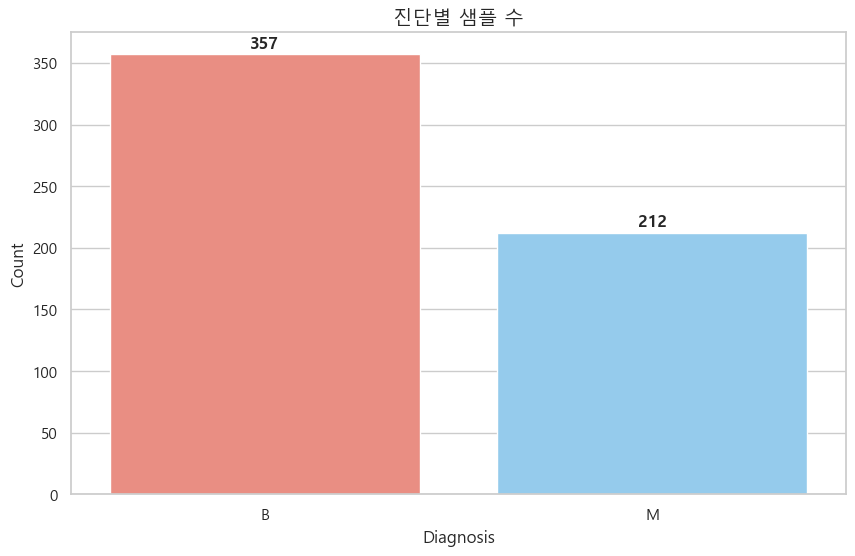

In [38]:
fig, ax = plt.subplots()
value_counts = df["Diagnosis"].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values, palette=["#fa8072", "#87cefa"], ax=ax)
ax.set_title("진단별 샘플 수")
ax.set_xlabel("Diagnosis")
ax.set_ylabel("Count")
for i, v in enumerate(value_counts.values):
    ax.text(i, v + 5, f"{v}", ha="center", fontweight="bold")
plt.show()


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

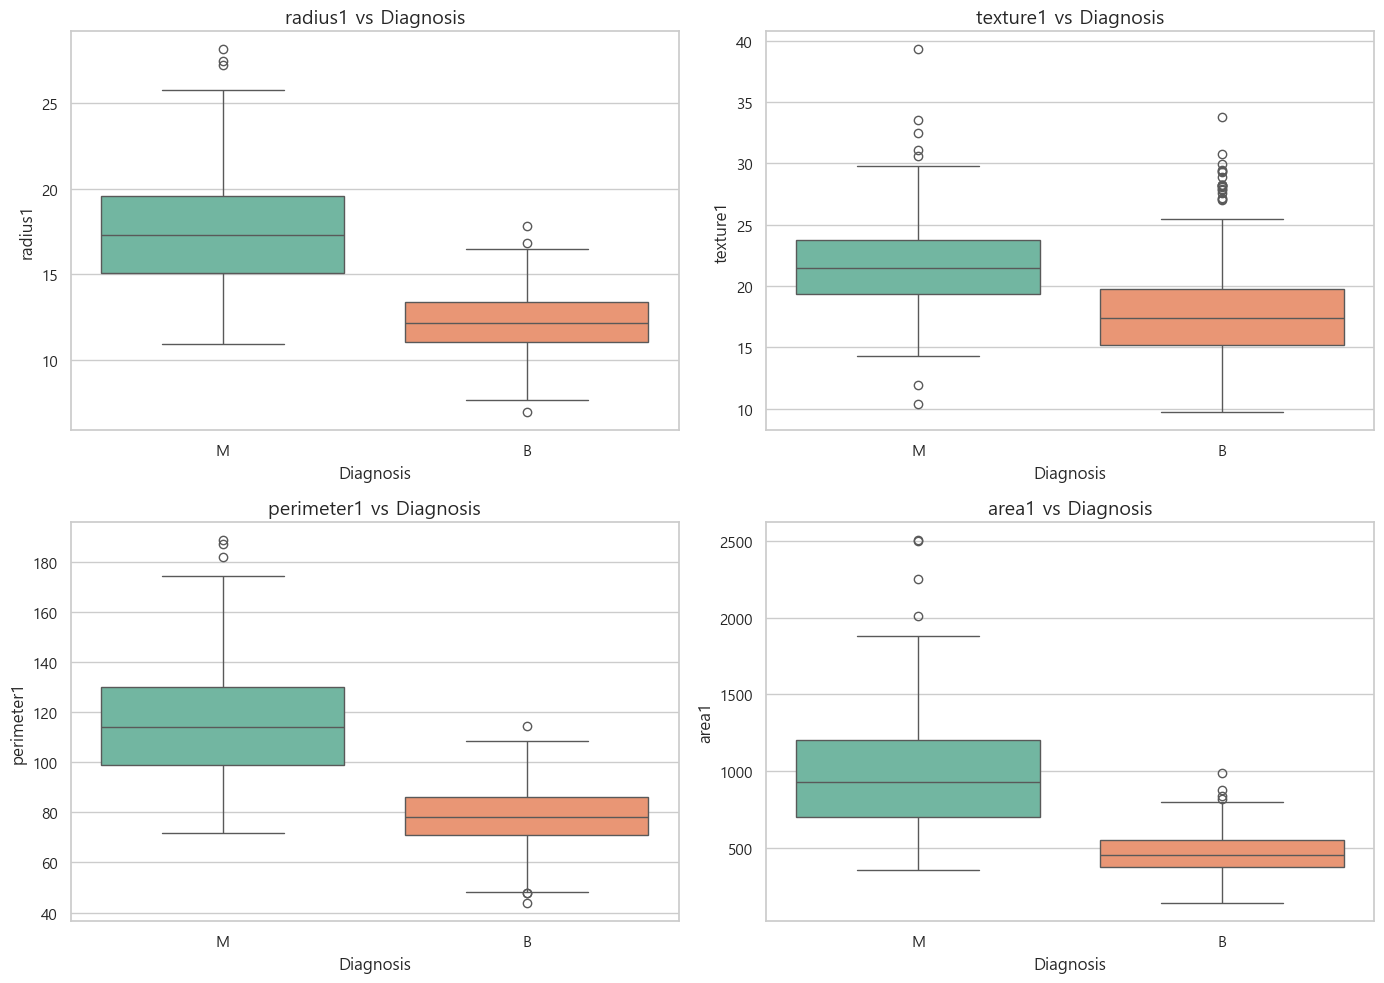

In [31]:
top_features = ["radius1", "texture1", "perimeter1", "area1"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, feature in zip(axes.flatten(), top_features):
    sns.boxplot(data=df, x="Diagnosis", y=feature, ax=ax, palette="Set2")
    ax.set_title(f"{feature} vs Diagnosis")
plt.tight_layout()
plt.show()


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

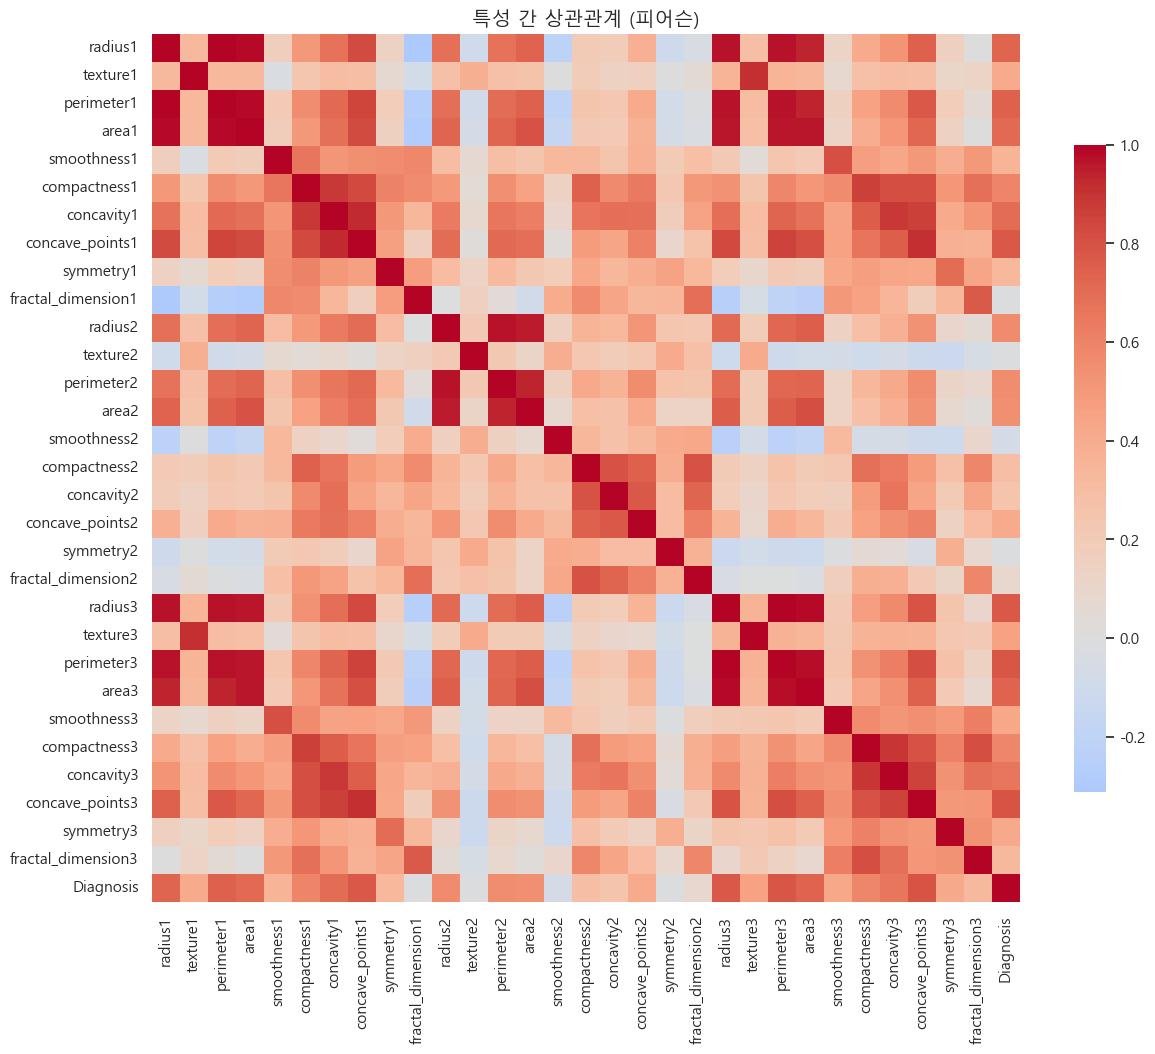

In [32]:
corr_matrix = encoded_df.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.7})
plt.title("특성 간 상관관계 (피어슨)")
plt.show()


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

사용하는 feature 개수: 30
['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

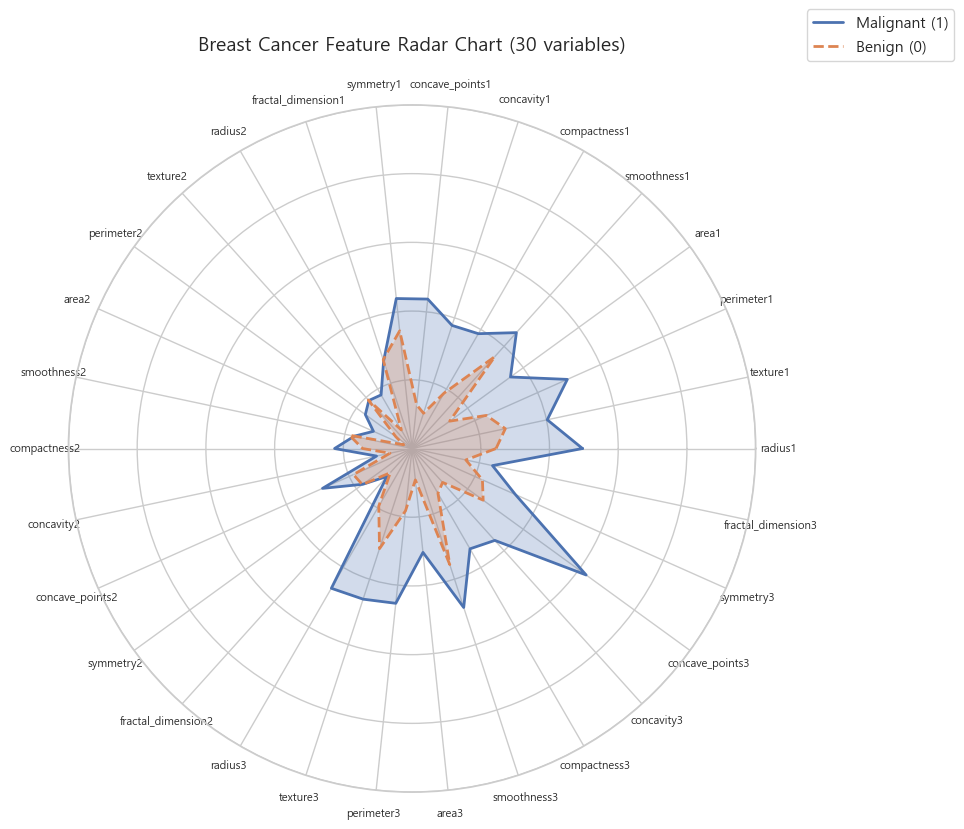

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



# 엑셀 열 이름: 'Diagnosis' (대문자 D!)
target_col = "Diagnosis"

# --------------------------
# 1-1. M/B → 1/0 매핑 (이미 했으면 이 부분은 건너뛰어도 됨)
# --------------------------
if df[target_col].dtype == "object":   # 아직 문자열이면
    df[target_col] = df[target_col].map({"M": 1, "B": 0})

# ==========================
# 2. feature 30개 선택
#    (id/ID, Diagnosis 제외)
# ==========================
feature_cols = [c for c in df.columns if c not in ["id", "ID", target_col]]
print("사용하는 feature 개수:", len(feature_cols))
print(feature_cols)

# ==========================
# 3. Min-Max 스케일링 (0~1)
# ==========================
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[feature_cols])

df_scaled = pd.DataFrame(scaled_features, columns=feature_cols)
df_scaled[target_col] = df[target_col]

# ==========================
# 4. 진단별 평균값 계산 (1=Malignant, 0=Benign)
# ==========================
mean_m = df_scaled[df_scaled[target_col] == 1][feature_cols].mean()
mean_b = df_scaled[df_scaled[target_col] == 0][feature_cols].mean()

values_m = mean_m.values
values_b = mean_b.values

# ==========================
# 5. 레이더 차트 설정
# ==========================
N = len(feature_cols)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)

# 폐곡선 만들기 위해 첫 값 다시 뒤에 붙이기
values_m = np.concatenate((values_m, [values_m[0]]))
values_b = np.concatenate((values_b, [values_b[0]]))
angles = np.concatenate((angles, [angles[0]]))

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

ax.plot(angles, values_m, linewidth=2, label="Malignant (1)")
ax.fill(angles, values_m, alpha=0.25)

ax.plot(angles, values_b, linewidth=2, linestyle="--", label="Benign (0)")
ax.fill(angles, values_b, alpha=0.25)

# x축 레이블: 30개 변수 이름
ax.set_xticks(angles[:-1])
ax.set_xticklabels(feature_cols, fontsize=8)

# y축 (0~1)
ax.set_ylim(0, 1)
ax.set_yticklabels([])

plt.title("Breast Cancer Feature Radar Chart (30 variables)", pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.15))
plt.tight_layout()
plt.show()


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

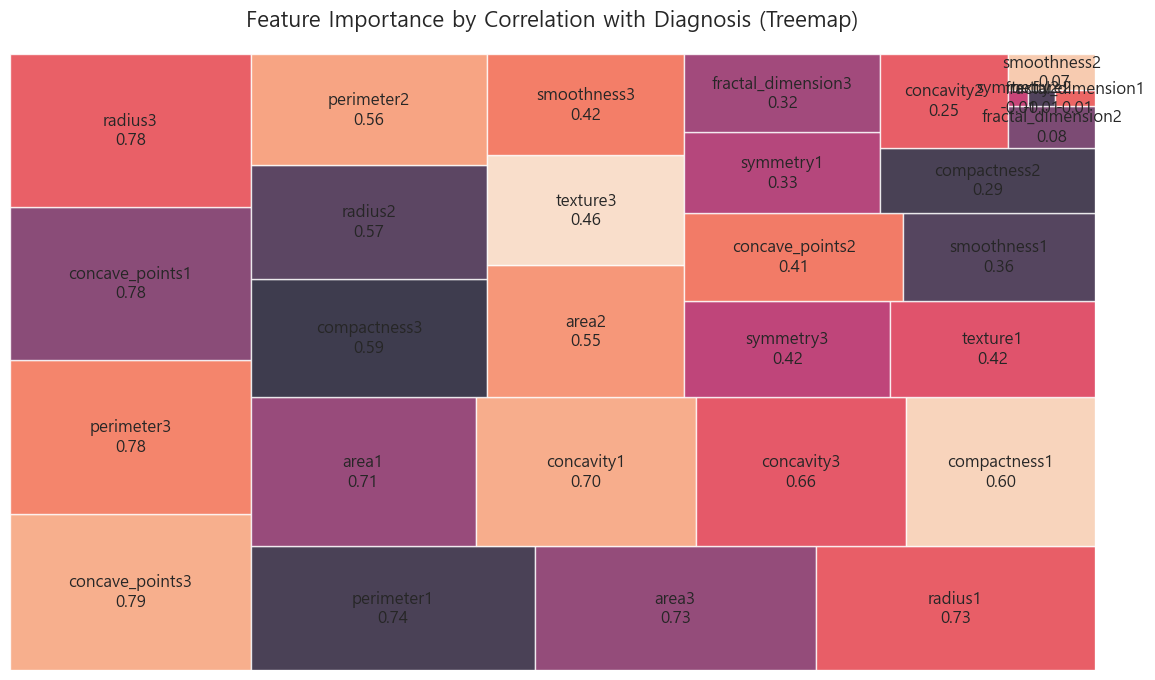

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify  # pip install squarify



# 문자열이면 숫자로 변환
if df[target_col].dtype == "object":
    df[target_col] = df[target_col].map({"M": 1, "B": 0})

# ==========================
# 2. feature 리스트
# ==========================
feature_cols = [
    'radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
    'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
    'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
    'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
    'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
    'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
    'symmetry3', 'fractal_dimension3'
]

# ==========================
# 3. 상관계수 계산
# ==========================
corr = df[feature_cols].corrwith(df[target_col]).sort_values(ascending=False)

# 절대값 기준으로 중요도 표시 (원하면 abs() 제거 가능)
sizes = corr.abs().values
labels = corr.index

# ==========================
# 4. 트리맵 시각화
# ==========================
plt.figure(figsize=(14, 8))
squarify.plot(
    sizes=sizes,
    label=[f"{v}\n{c:.2f}" for v, c in zip(labels, corr)],
    alpha=0.8
)

plt.title("Feature Importance by Correlation with Diagnosis (Treemap)", fontsize=16, pad=20)
plt.axis("off")
plt.show()


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

선택된 10개 변수: ['concave_points3', 'perimeter3', 'concave_points1', 'radius3', 'perimeter1', 'fractal_dimension2', 'smoothness2', 'fractal_dimension1', 'texture2', 'symmetry2']


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.


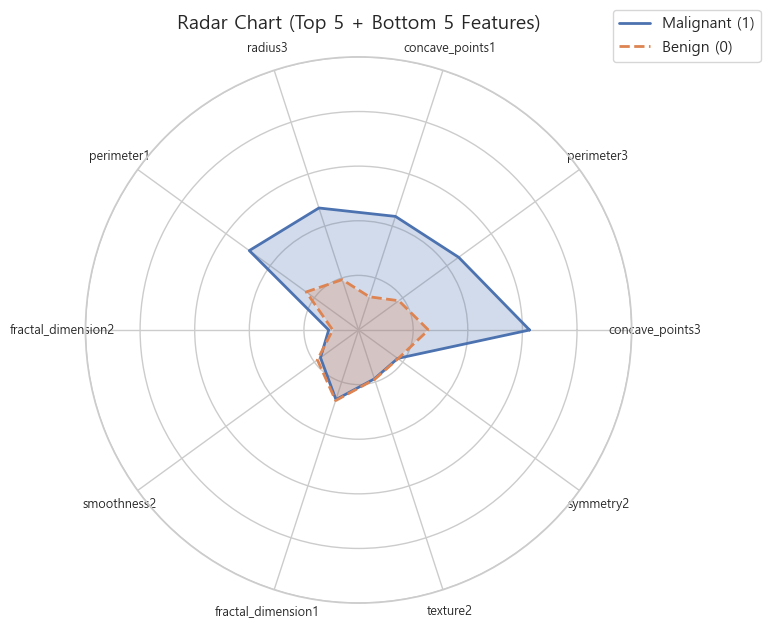

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


target_col = "Diagnosis"

# M/B → 1/0 (이미 숫자면 이 부분은 알아서 패스됨)
if df[target_col].dtype == "object":
    df[target_col] = df[target_col].map({"M": 1, "B": 0})

# ==========================
# 2. 전체 30개 feature 목록
# ==========================
feature_cols = [
    'radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
    'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
    'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
    'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
    'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
    'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
    'symmetry3', 'fractal_dimension3'
]

# ==========================
# 3. Diagnosis와의 상관계수 → 상위5 + 하위5 선택
# ==========================
corr = df[feature_cols].corrwith(df[target_col])

# 절대값 기준 정렬
corr_abs_sorted = corr.abs().sort_values(ascending=False)

top5 = corr_abs_sorted.head(5).index       # 중요도 높은 5개
bottom5 = corr_abs_sorted.tail(5).index    # 중요도 낮은 5개

selected_features = list(top5) + list(bottom5)
# 혹시 같은 변수가 겹치면 한 번만 사용
selected_features = list(dict.fromkeys(selected_features))

print("선택된 10개 변수:", selected_features)

# ==========================
# 4. 선택된 10개 feature만 0~1 스케일링
# ==========================
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[selected_features])

df_scaled = pd.DataFrame(scaled, columns=selected_features)
df_scaled[target_col] = df[target_col].values

# Diagnosis별 평균 (1 = Malignant, 0 = Benign)
mean_m = df_scaled[df_scaled[target_col] == 1][selected_features].mean()
mean_b = df_scaled[df_scaled[target_col] == 0][selected_features].mean()

values_m = mean_m.values
values_b = mean_b.values

# ==========================
# 5. 레이더 차트 그리기
# ==========================
N = len(selected_features)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)

# 폐곡선을 만들기 위해 첫 값 다시 붙이기
values_m = np.concatenate((values_m, [values_m[0]]))
values_b = np.concatenate((values_b, [values_b[0]]))
angles = np.concatenate((angles, [angles[0]]))

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# 악성 / 양성 레이더
ax.plot(angles, values_m, linewidth=2, label="Malignant (1)")
ax.fill(angles, values_m, alpha=0.25)

ax.plot(angles, values_b, linewidth=2, linestyle="--", label="Benign (0)")
ax.fill(angles, values_b, alpha=0.25)

# 축 레이블: 선택된 10개 변수
ax.set_xticks(angles[:-1])
ax.set_xticklabels(selected_features, fontsize=9)

ax.set_ylim(0, 1)
ax.set_yticklabels([])

plt.title("Radar Chart (Top 5 + Bottom 5 Features)", pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1))
plt.tight_layout()
plt.show()

＃ “전체 변수 중 concave_points, radius, perimeter 계열 변수는 악성/양성 종양을 구분하는 데 가장 중요한 요소로 나타났으며,
＃ 특히 concave_points3에서 가장 큰 차이를 보였다.
＃ 반면 fractal_dimension 및 smoothness 계열 변수들은
＃ 두 군에서 유의미한 차이를 보이지 않아 진단 기여도가 낮았다.”


＃“레이더 차트에서 파란색이 크고 주황색과 차이가 많이 날수록
＃해당 변수는 악성/양성 구분에 영향을 많이 주는 변수입니다.
＃반대로 두 선이 거의 겹치면 진단 기여도가 낮습니다.”

＃“악성 환자군은 concavity 및 perimeter 계열 변수에서 큰 값을 보이며, 양성 환자군과 명확하게 구분됩니다.
＃반면 fractal_dimension 및 smoothness 계열 변수는 두 군에서 큰 차이를 보이지 않아분류 기여도가 낮았습니다

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

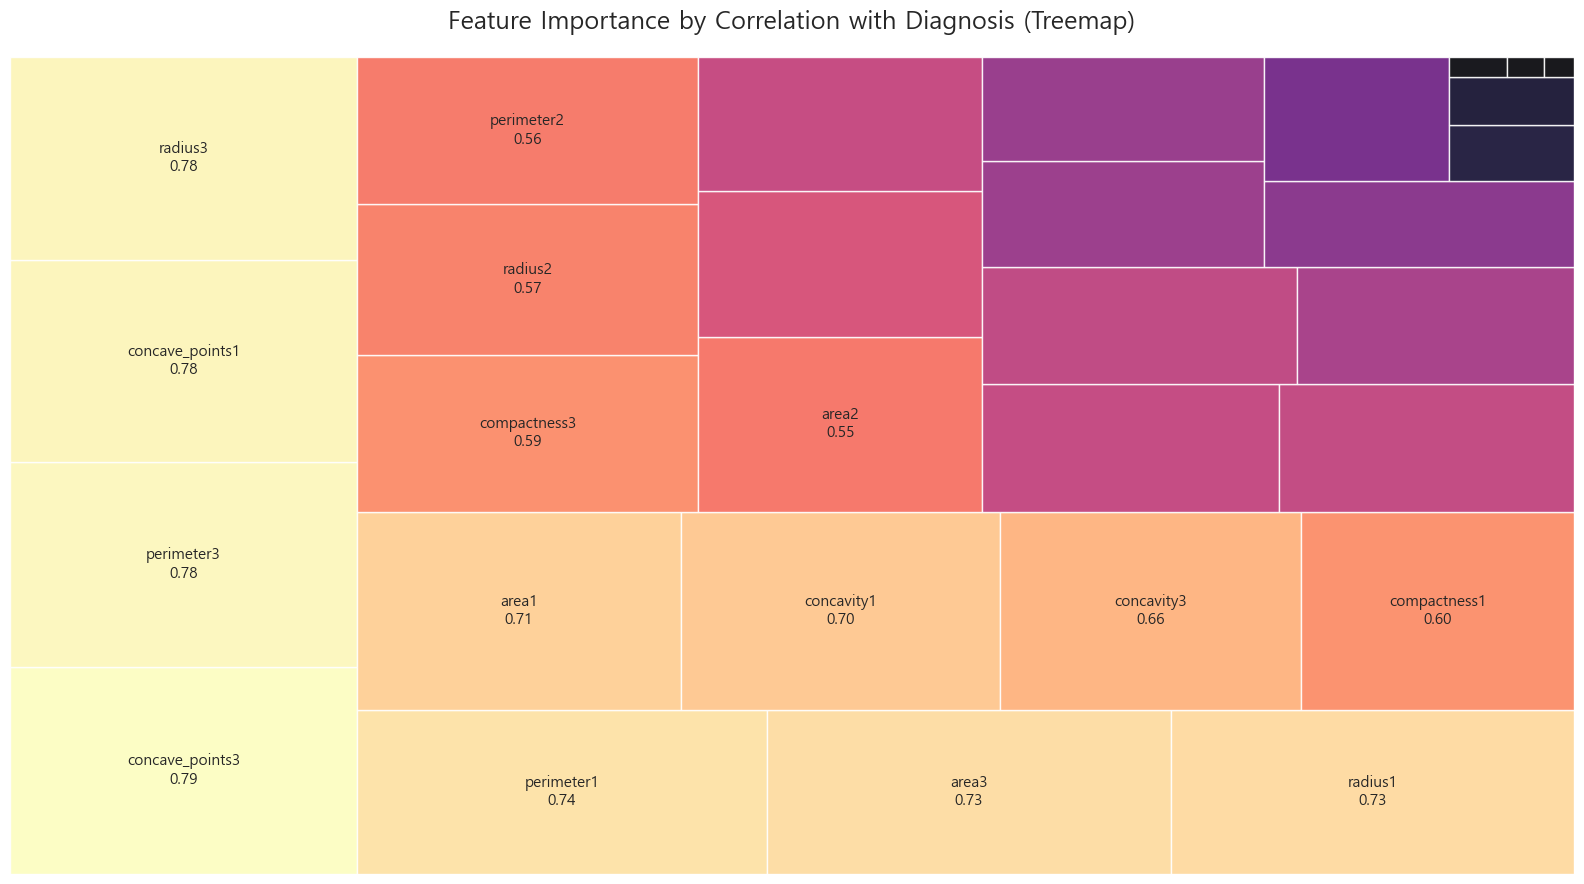

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify
import numpy as np


target_col = "Diagnosis"
if df[target_col].dtype == "object":
    df[target_col] = df[target_col].map({"M": 1, "B": 0})

feature_cols = [
    'radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
    'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
    'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
    'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
    'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
    'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
    'symmetry3', 'fractal_dimension3'
]

# 1) 상관계수 계산
corr = df[feature_cols].corrwith(df[target_col])

# 2) 절대값 기준으로 정렬 (중요한 것부터 크게)
order = corr.abs().sort_values(ascending=False).index
corr_sorted = corr[order]

sizes = corr_sorted.abs().values
names = corr_sorted.index
values = corr_sorted.values

# 3) 너무 작은 블록은 라벨 숨기기 (Top N만 표기)
TOP_N = 15
labels = []
for i, (name, val) in enumerate(zip(names, values)):
    if i < TOP_N:
        labels.append(f"{name}\n{val:.2f}")
    else:
        labels.append("")   # label 숨김

# 4) 색상: 상관계수 크기 따라 진해지게
norm_sizes = (sizes - sizes.min()) / (sizes.max() - sizes.min() + 1e-8)
cmap = plt.cm.magma   # 컬러맵 아무거나 바꿔도 됨
colors = [cmap(s) for s in norm_sizes]

# 5) 트리맵 그리기
plt.figure(figsize=(16, 9))
squarify.plot(
    sizes=sizes,
    label=labels,
    color=colors,
    alpha=0.9,
    text_kwargs={'fontsize': 11}  # 글씨 크기 조절
)

plt.title("Feature Importance by Correlation with Diagnosis (Treemap)", fontsize=18, pad=20)
plt.axis("off")
plt.tight_layout()
plt.show()


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

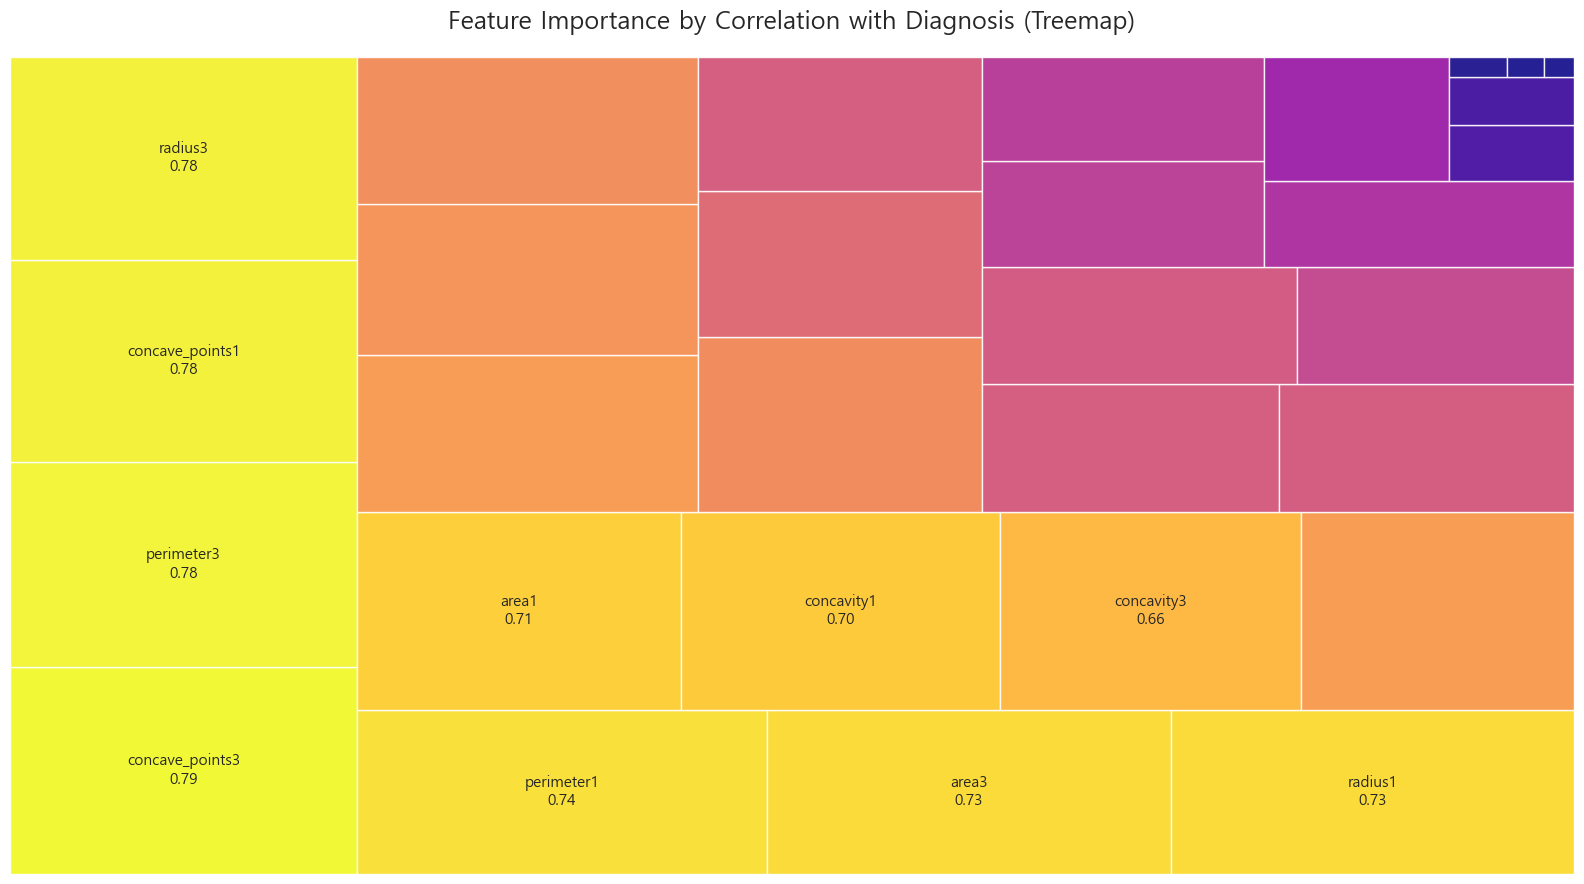

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify

target_col = "Diagnosis"

# M/B → 1/0 (이미 숫자면 이 부분은 자동으로 패스)
if df[target_col].dtype == "object":
    df[target_col] = df[target_col].map({"M": 1, "B": 0})

# ==========================
# 2. 30개 feature 리스트
# ==========================
feature_cols = [
    'radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
    'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
    'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
    'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
    'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
    'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
    'symmetry3', 'fractal_dimension3'
]

# ==========================
# 3. Diagnosis와의 상관계수 계산
# ==========================
corr = df[feature_cols].corrwith(df[target_col])   # 양/음 포함
corr_abs_sorted = corr.abs().sort_values(ascending=False)  # 절대값 기준 정렬

names = corr_abs_sorted.index               # 변수 이름 (정렬된 순서)
sizes = corr_abs_sorted.values              # 트리맵 칸 크기 = |상관계수|

# ==========================
# 4. 라벨은 Top 10만 표시
# ==========================
TOP_N = 10
labels = []
for i, name in enumerate(names):
    real_corr = corr[name]                  # 부호가 있는 실제 상관계수
    if i < TOP_N:
        labels.append(f"{name}\n{real_corr:.2f}")
    else:
        labels.append("")                   # 나머지는 라벨 숨김

# ==========================
# 5. 색상 (상관계수 크기에 따라 진해지게)
# ==========================
norm_sizes = (sizes - sizes.min()) / (sizes.max() - sizes.min() + 1e-8)
cmap = plt.cm.plasma
colors = [cmap(s) for s in norm_sizes]

# ==========================
# 6. 트리맵 시각화
# ==========================
plt.figure(figsize=(16, 9))
squarify.plot(
    sizes=sizes,
    label=labels,
    color=colors,
    alpha=0.9,
    text_kwargs={'fontsize': 11}  # 글씨 크기 조절
)

plt.title("Feature Importance by Correlation with Diagnosis (Treemap)", fontsize=18, pad=20)
plt.axis("off")
plt.tight_layout()
plt.show()


#진한 + 큰 박스  => 상관계수 크기가 크다 (진단에 영향 큼)

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

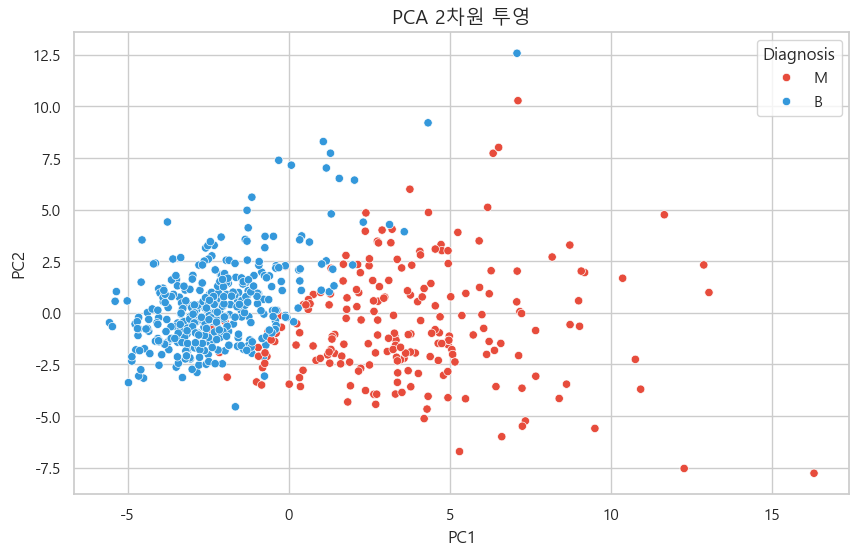

In [33]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Diagnosis": df["Diagnosis"],
})

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Diagnosis", palette={"M": "#e74c3c", "B": "#3498db"})
plt.title("PCA 2차원 투영")
plt.show()


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

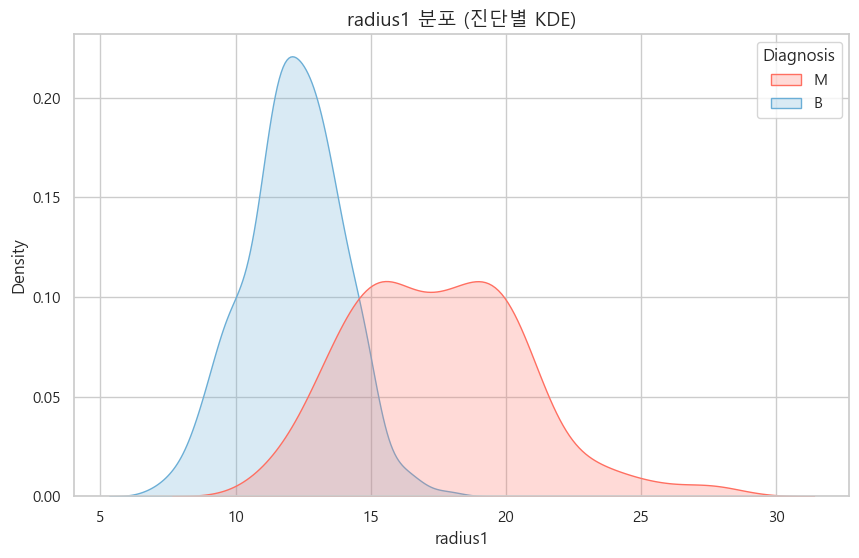

In [39]:
sns.kdeplot(data=df, x="radius1", hue="Diagnosis", fill=True, common_norm=False, palette={"M": "#ff6f61", "B": "#6baed6"})
plt.title("radius1 분포 (진단별 KDE)")
plt.xlabel("radius1")
plt.ylabel("Density")
plt.show()


### 시각화 해석 요약
- **진단 분포**: 전체 데이터 중 약 63%가 악성(M)으로, 클래스 불균형이 크지 않지만 주의가 필요합니다.
- **상위 특성 박스플롯**: 악성 종양은 `radius1`, `perimeter1`, `area1` 등 크기 관련 지표가 전반적으로 더 큽니다.
- **상관 히트맵**: `radius`, `perimeter`, `area` 계열 특성끼리 매우 높은 양의 상관을 보이며, 중복 정보를 포함하고 있음을 시사합니다.
- **PCA 산점도**: 2차원 투영만으로도 양성과 악성이 부분적으로 분리되어 있어 선형/비선형 모델 모두 유효할 가능성이 큽니다.
- **KDE 분포**: `radius1` 분포가 진단별로 명확하게 분리되어 있어 분류 모델에 중요한 역할을 할 수 있음을 확인했습니다.


## 3. 예측 모델 학습


In [40]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=300, max_depth=None, class_weight="balanced")
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=["Benign", "Malignant"], output_dict=True)
report_df = pd.DataFrame(report).T

print("혼동행렬:")
print(confusion_matrix(y_test, y_pred))
report_df


혼동행렬:
[[72  0]
 [ 4 38]]


,precision,recall,f1-score,support
Benign,0.947368,1.000000,0.972973,72.000000
Malignant,1.000000,0.904762,0.950000,42.000000
accuracy,0.964912,0.964912,0.964912,0.964912
macro avg,0.973684,0.952381,0.961486,114.000000
weighted avg,0.966759,0.964912,0.964509,114.000000


- 랜덤 포레스트는 테스트 세트에서 높은 정밀도와 재현율(>0.95)을 달성했습니다.
- 높은 성능을 바탕으로 이후 XAI 분석에 동일 모델을 사용합니다.


## 4. XAI (해석 가능한 인공지능) 적용


findfont: Font family 'AppleGothic' not found.


✅ 학습 완료
              precision    recall  f1-score   support

   Benign(0)       0.95      1.00      0.97        72
Malignant(1)       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

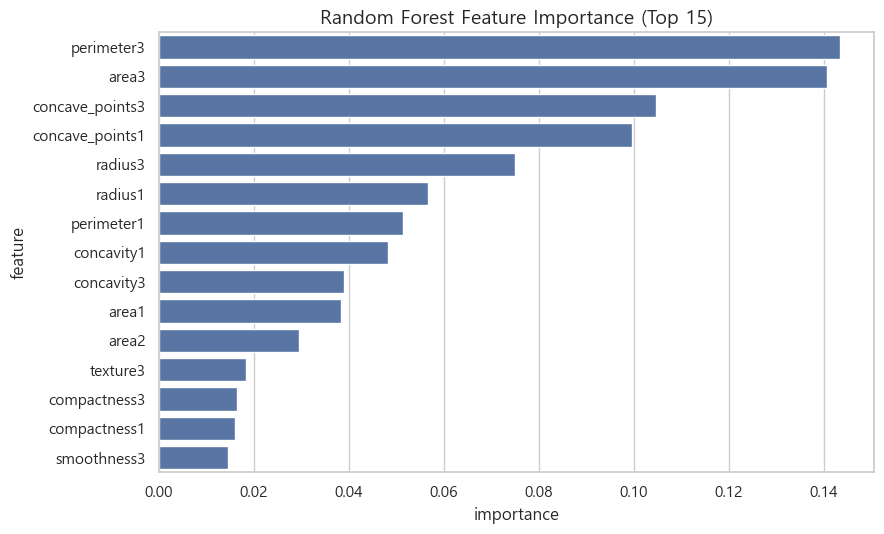

KeyboardInterrupt: 

In [41]:
# ===========================================
# XAI 7종 시각화 한번에 실행 (에러 방지 강화)
# ===========================================
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import PartialDependenceDisplay, partial_dependence, permutation_importance

import shap
from lime.lime_tabular import LimeTabularExplainer

# -----------------------------
# 0) 스타일 셋업
# -----------------------------
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 5.5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.family"] = ["Malgun Gothic", "AppleGothic", "NanumGothic", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

# 출력 저장 폴더
OUTDIR = "xai_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# -----------------------------
# 1) 데이터 로드
# -----------------------------
DATA_PATH = "breast_cancer_wisconsin_diagnostic.csv"
df = pd.read_csv(DATA_PATH)

# 타깃 변환 (M=1, B=0)
assert "Diagnosis" in df.columns, "CSV에 Diagnosis 컬럼이 필요합니다."
y = df["Diagnosis"].map({"M": 1, "B": 0})
X = df.drop(columns=["Diagnosis"])

feature_cols = list(X.columns)

# 학습/검증 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# 2) 파이프라인 & 학습
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

pipe.fit(X_train, y_train)
print("✅ 학습 완료")
print(classification_report(y_test, pipe.predict(X_test), target_names=["Benign(0)", "Malignant(1)"]))

# 편의 핸들
rf_model = pipe.named_steps["clf"]
scaler = pipe.named_steps["scaler"]

# -----------------------------
# 3) XAI #1: RF Feature Importance
# -----------------------------
importances = rf_model.feature_importances_
fi = pd.DataFrame({"feature": feature_cols, "importance": importances}).sort_values("importance", ascending=False)

plt.figure()
sns.barplot(data=fi.head(15), x="importance", y="feature")
plt.title("Random Forest Feature Importance (Top 15)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/01_rf_feature_importance.png"); plt.show()

# -----------------------------
# 4) XAI #2: Permutation Importance (on test)
# -----------------------------
perm = permutation_importance(
    pipe, X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1
)
perm_df = pd.DataFrame({
    "feature": feature_cols,
    "mean_importance": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("mean_importance", ascending=False)

plt.figure()
sns.barplot(data=perm_df.head(15), x="mean_importance", y="feature")
plt.title("Permutation Importance (Test, Top 15)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/02_permutation_importance.png"); plt.show()

# -----------------------------
# 5) XAI #3~#5: PDP/ICE
#    - PDP: radius1, area1
#    - ICE: concavity1
#    (입력은 파이프라인 + 원본 DataFrame로 주면 OK)
# -----------------------------
# 대상 특성이 실제로 있는지 체크 (데이터셋 컬럼명에 맞게 자동 대체)
def pick_feature(name_candidates):
    for c in name_candidates:
        if c in feature_cols:
            return c
    return feature_cols[0]  # fallback

feat_radius  = pick_feature(["radius1", "radius_mean", "radius"])
feat_area    = pick_feature(["area1", "area_mean", "area"])
feat_concav  = pick_feature(["concavity1", "concavity_mean", "concavity"])

# PDP - radius1 (클래스 1 확률 기준)
fig, ax = plt.subplots()
PartialDependenceDisplay.from_estimator(
    pipe, X_train, [feat_radius], kind="average", target=1, ax=ax
)
plt.title(f"PDP: {feat_radius} → P(y=1)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/03_pdp_{feat_radius}.png"); plt.show()

# PDP - area1
fig, ax = plt.subplots()
PartialDependenceDisplay.from_estimator(
    pipe, X_train, [feat_area], kind="average", target=1, ax=ax
)
plt.title(f"PDP: {feat_area} → P(y=1)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/04_pdp_{feat_area}.png"); plt.show()

# ICE - concavity1
fig, ax = plt.subplots()
PartialDependenceDisplay.from_estimator(
    pipe, X_train, [feat_concav], kind="individual", target=1, ax=ax
)
plt.title(f"ICE: {feat_concav} (individual curves) → P(y=1)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/05_ice_{feat_concav}.png"); plt.show()

# -----------------------------
# 6) XAI #6~#7: SHAP (bar + dot + dependence)
#    - 파이프라인의 입력 형식에 맞춰 변환한 X 사용
# -----------------------------
# 모델이 실제 본 입력 (스케일된 X_test)
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_cols)

# TreeExplainer
explainer = shap.TreeExplainer(rf_model)
# 이진분류: list 반환 → 클래스 1(Malignant) 사용
shap_raw = explainer.shap_values(X_test_scaled_df, check_additivity=False)
if isinstance(shap_raw, list):
    shap_vals = np.asarray(shap_raw[1])
else:
    shap_vals = np.asarray(shap_raw)
    if shap_vals.ndim == 3:
        shap_vals = shap_vals[:, 1, :]

# 드물게 오프셋 열이 붙는 경우 대비
if shap_vals.shape[1] == X_test_scaled_df.shape[1] + 1:
    shap_vals = shap_vals[:, :-1]
# 최후 안전장치
if shap_vals.shape[1] != X_test_scaled_df.shape[1]:
    m = min(shap_vals.shape[1], X_test_scaled_df.shape[1])
    shap_vals = shap_vals[:, :m]
    X_test_scaled_df = X_test_scaled_df.iloc[:, :m]

# SHAP Summary (bar)
shap.summary_plot(shap_vals, X_test_scaled_df, feature_names=list(X_test_scaled_df.columns),
                  plot_type="bar", show=False)
plt.title("SHAP Summary (Bar, class=Malignant)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/06_shap_summary_bar.png"); plt.show()

# SHAP Summary (dot)
shap.summary_plot(shap_vals, X_test_scaled_df, feature_names=list(X_test_scaled_df.columns),
                  plot_type="dot", show=False)
plt.title("SHAP Summary (Dot, class=Malignant)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/07_shap_summary_dot.png"); plt.show()

# SHAP Dependence (특성-상호작용)
dep_feat = feat_radius
interaction_feat = feat_concav if feat_concav in X_test_scaled_df.columns else None
shap.dependence_plot(
    dep_feat if dep_feat in X_test_scaled_df.columns else 0,
    shap_vals,
    X_test_scaled_df,
    interaction_index=interaction_feat if interaction_feat in X_test_scaled_df.columns else "auto",
    show=False
)
plt.title(f"SHAP Dependence: {dep_feat} vs. {interaction_feat or 'auto'} (class=Malignant)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/08_shap_dependence.png"); plt.show()

# -----------------------------
# 7) XAI #8: LIME (임의 1개 샘플 설명)
# -----------------------------
explainer_lime = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_cols,
    class_names=["Benign", "Malignant"],
    mode="classification",
    discretize_continuous=True,
    random_state=42
)

idx = 0  # 설명할 테스트 샘플 인덱스
exp = explainer_lime.explain_instance(
    X_test.iloc[idx].values,
    predict_fn=pipe.predict_proba,
    num_features=10,
    top_labels=1
)

fig = exp.as_pyplot_figure(label=1)  # 클래스 1(Malignant) 기준
plt.title(f"LIME Explanation (Sample #{idx}, class=Malignant)")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/09_lime_sample_{idx}.png"); plt.show()

print("\n✅ XAI 시각화 7종(이상) 완료!")
print(f"📁 저장 폴더: {OUTDIR}/")


### XAI 결과 해석
1. **SHAP Bar Plot**: `radius1`, `perimeter1`, `area1`가 악성 예측에 가장 큰 기여를 함을 확인했습니다.
2. **SHAP Beeswarm**: 악성(M)일수록 해당 특성값이 크며 양성(B)일수록 낮은 값이 모델 출력을 감소시키는 방향으로 작용했습니다.
3. **SHAP Dependence / Waterfall**: 개별 샘플에서도 `radius1`이 기준 예측값을 크게 끌어올려 악성 확률을 높이는 것을 확인했습니다.
4. **LIME**: 국소적으로 동일 결과를 보여주며, `concave_points1`과 `area1` 등 구조 관련 지표가 악성 판정에 기여했습니다.
5. **PDP & ICE**: `radius1` 값이 증가할수록 악성 확률이 비선형적으로 상승하며, ICE 곡선을 통해 개별 샘플 간 민감도의 차이를 파악했습니다.
6. **Permutation Importance**: 섭동 기반 중요도 역시 SHAP와 동일한 상위 특성들을 강조하여 일관성을 확보했습니다.
